<a href="https://colab.research.google.com/github/PoojaB24/EcoAssistantAgent/blob/main/new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


This block imports the required libraries for data processing, text cleaning, and machine learning, including tools for model training, feature extraction (TF-IDF), and evaluation of performance. It also brings in visualization libraries like Matplotlib and Seaborn to help display model results and analyze patterns in the data.

In [ ]:

# ============================
# 1️⃣ Load Dataset
# ============================
df = pd.read_csv("flipkart_products_with_fixed_labels.csv")

label_map = {
    "not eco-friendly": 0,
    "moderate": 1,
    "eco-friendly": 2
}

df["label"] = df["Eco_Label_Fixed"].str.strip().str.lower().map(label_map)
df = df.dropna(subset=["label"])

This block loads the dataset from a CSV file and converts the text-based eco labels into numerical values using a defined mapping. Rows without valid labels are removed to ensure clean and consistent data for training the machine learning model.

In [ ]:
df.head()

,uniq_id,product_name,brand,spec_readable,Eco_Label_Fixed,label
0,c2d766ca982eca8304150849735ffef9,Alisha Solid Women's Cycling Shorts,Alisha,Number of Contents in Sales Package: Pack of 3...,Eco-Friendly,2.0
1,7f7036a6d550aaa89d34c77bd39a5e48,FabHomeDecor Fabric Double Sofa Bed,FabHomeDecor,Installation & Demo Details: Installation and ...,Eco-Friendly,2.0
2,f449ec65dcbc041b6ae5e6a32717d01b,AW Bellies,AW,Ideal For: Women; Occasion: Casual; Color: Red...,Not Eco-Friendly,0.0
3,0973b37acd0c664e3de26e97e5571454,Alisha Solid Women's Cycling Shorts,Alisha,Number of Contents in Sales Package: Pack of 2...,Eco-Friendly,2.0
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,Sicons All Purpose Arnica Dog Shampoo,Sicons,Pet Type: Dog; Brand: Sicons; Quantity: 500 ml...,Not Eco-Friendly,0.0


In [ ]:
df.describe()

,label
count,28510.000000
mean,1.200105
std,0.852877
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


Gives a statistical summary of the dataset (like mean, min, max, and standard deviation).

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28510 entries, 0 to 28510
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   uniq_id          28510 non-null  object 
 1   product_name     28510 non-null  object 
 2   brand            22646 non-null  object 
 3   spec_readable    28443 non-null  object 
 4   Eco_Label_Fixed  28510 non-null  object 
 5   label            28510 non-null  float64
dtypes: float64(1), object(5)
memory usage: 1.5+ MB


Provides a concise overview of the dataset’s structure, including column names, data types, and number of non-null values.

In [ ]:
print(df.columns)


Index(['uniq_id', 'product_name', 'brand', 'spec_readable', 'Eco_Label_Fixed',
       'label'],
      dtype='object')


Prints the names of all columns in the dataset, helping to understand the available features and verify that the required columns for analysis and modeling are present.

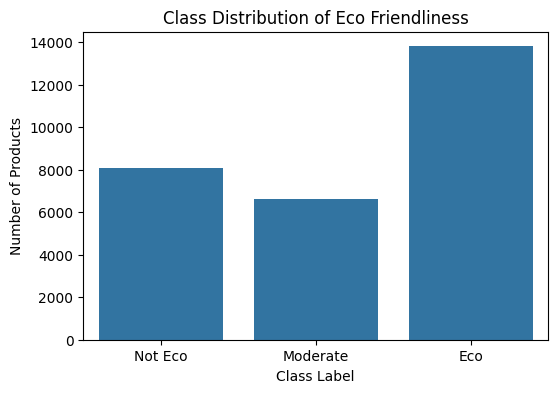

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["label"])

plt.xticks([0,1,2], ["Not Eco", "Moderate", "Eco"])
plt.xlabel("Class Label")
plt.ylabel("Number of Products")
plt.title("Class Distribution of Eco Friendliness")
plt.show()


This block visualizes the distribution of products across the three eco-friendliness classes using a count plot. It helps identify any class imbalance in the dataset, which is important for understanding model bias and performance.


In [ ]:
# ============================
# 2️⃣ Text Cleaning Function
# ============================
def clean_text(text):
    if pd.isna(text): return ""
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df["text_clean"] = (
    df["product_name"].fillna("") + " " +
    df["brand"].fillna("") + " " +
    df["spec_readable"].fillna("")
).apply(clean_text)

X = df["text_clean"]
y = df["label"]


This block defines a text-cleaning function that converts text to lowercase, removes special characters, and extra spaces to make the data uniform. It then combines important product fields into a single cleaned text column and separates the inputs (X) and output labels (y) for model training.


In [ ]:
# ============================
# 3️⃣ Train/Test Split
# ============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=10, stratify=y
)


This block splits the dataset into training and testing sets, with 80% of the data used for training and 20% for testing. Stratification ensures that all eco-friendliness classes are proportionally represented in both sets.


In [ ]:
# ============================
# 4️⃣ Word TF-IDF + Char TF-IDF
# ============================
tfidf_word = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1,2),
    min_df=2,
    max_df=0.8
)

tfidf_char = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3,5),
    min_df=2
)

# Combined features
combined_features = FeatureUnion([
    ("word", tfidf_word),
    ("char", tfidf_char)
])

This block creates two TF-IDF vectorizers: one for word-level features (unigrams and bigrams) and another for character-level n-grams to capture finer text patterns. Both vectorizers are then combined using FeatureUnion to produce a richer and more informative feature set for the model.


In [ ]:

# ============================
# 5️⃣ Build Combined Pipeline
# ============================
pipeline = Pipeline([
    ("features", combined_features),
    ("clf", LinearSVC(class_weight="balanced"))
])

This block builds a machine learning pipeline that first transforms the text using the combined TF-IDF features and then applies a Linear Support Vector Classifier for prediction. The `class_weight="balanced"` option helps handle class imbalance by giving appropriate importance to underrepresented classes.


1.Extracts features using your combined TF-IDF vectorizers.

2.Trains a Linear SVM classifier (LinearSVC) with balanced class weights.

LinearSVC (Support Vector Machine with linear kernel) is great for text classification because:

[1]Works well with high-dimensional sparse TF-IDF features

[2]Very fast for large datasets

[3]Robust to noise

[4]Often beats Logistic Regression for text tasks


In [ ]:
# ===== Train the model =====
pipeline.fit(X_train, y_train)

# ===== Training Accuracy =====
y_train_pred = pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# ===== Testing Accuracy =====
y_test_pred = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("✅ Training Accuracy:", train_accuracy)
print("✅ Testing Accuracy :", test_accuracy)

# (Optional) Detailed report
print("\n📊 Test Classification Report:\n")
print(classification_report(y_test, y_test_pred))


✅ Training Accuracy: 0.9984216064538758
✅ Testing Accuracy : 0.9817607856892319

📊 Test Classification Report:

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1618
         1.0       0.97      0.98      0.97      1326
         2.0       0.99      0.98      0.99      2758

    accuracy                           0.98      5702
   macro avg       0.98      0.98      0.98      5702
weighted avg       0.98      0.98      0.98      5702



In [ ]:
# ============================
# 6️⃣ Hyperparameter Optimization
# ============================
param_grid = {
    "clf__C": [0.5, 1, 2],
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=2
)

print("\nTraining model... please wait...\n")
grid.fit(X_train, y_train)

print(f"\nBest Model Parameters: {grid.best_params_}")

best_model = grid.best_estimator_


Training model... please wait...

Fitting 5 folds for each of 3 candidates, totalling 15 fits

Best Model Parameters: {'clf__C': 2}


This block performs hyperparameter tuning using GridSearchCV to find the best value of the regularization parameter (C) for the Linear SVM model. It trains multiple models with cross-validation and selects the best-performing model based on the macro F1-score for improved and balanced classification performance.

Low C (0.5) → simpler model, softer margin, may underfit

Medium C (1) → balanced

Higher C (2) → more strict, may overfit

SVM performs best in small C range (0.1–10) and also our data set has ~27k entries.

cv=5

Split the training data into 5 equal parts

Train on 4 parts, test on the remaining 1

Repeat 5 times (each part becomes test once)

f1_macro:Gives equal weight to each class.Good for imbalanced classification.

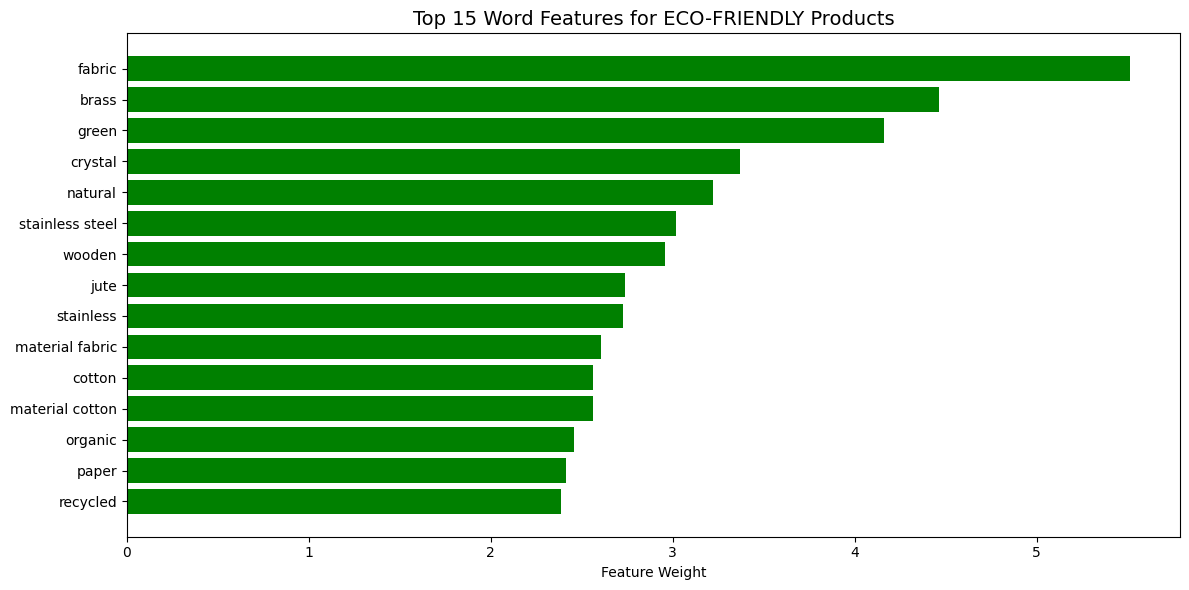

In [ ]:
# ============================
# 📊 Top Important WORD Features (Eco-Friendly)
# ============================

vectorizer = best_model.named_steps['features'].transformer_list[0][1]
classifier = best_model.named_steps['clf']

feature_names = vectorizer.get_feature_names_out()
word_coefs = classifier.coef_[2][:len(feature_names)]   # class 2 = Eco

top_idx = np.argsort(word_coefs)[-15:]

plt.figure(figsize=(12,6))
plt.barh(feature_names[top_idx], word_coefs[top_idx], color="green")
plt.title("Top 15 Word Features for ECO-FRIENDLY Products", fontsize=14)
plt.xlabel("Feature Weight")
plt.tight_layout()
plt.show()


This block extracts the most influential **word-level features** that push the model to predict the *eco-friendly* class and ranks them based on their weight. It then visualizes the top 15 important words in a horizontal bar chart, helping interpret which terms strongly indicate eco-friendly products.


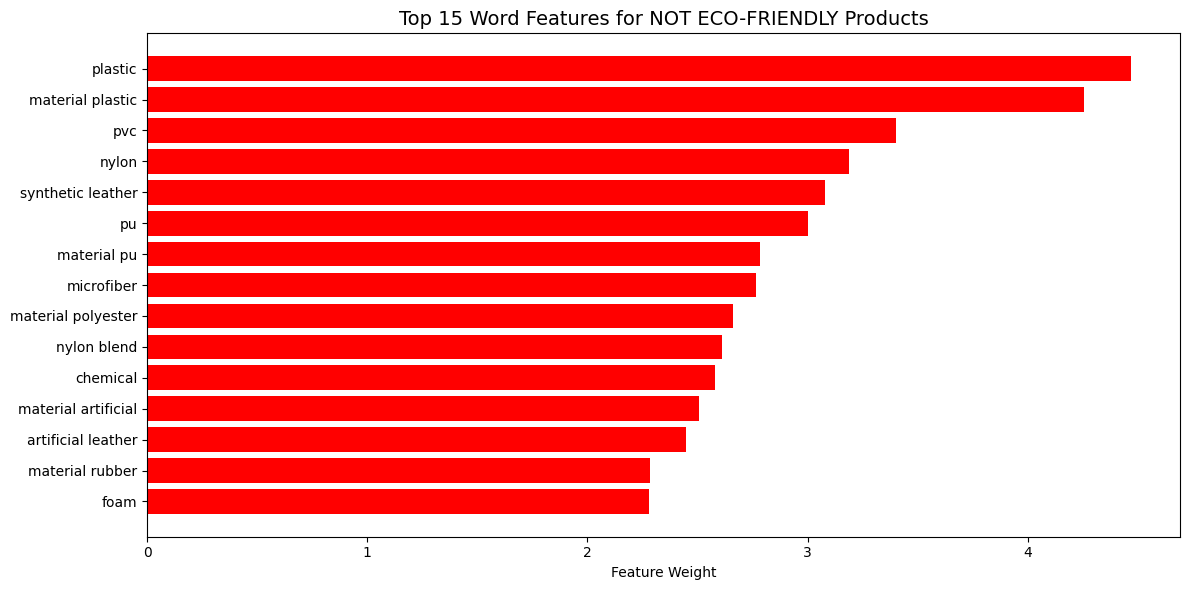

In [ ]:
# ============================
# 📊 Top Important WORD Features (Not Eco-Friendly)
# ============================

vectorizer = best_model.named_steps['features'].transformer_list[0][1]
classifier = best_model.named_steps['clf']

feature_names = vectorizer.get_feature_names_out()
word_coefs = classifier.coef_[0][:len(feature_names)]   # class 0 = Not Eco

top_idx = np.argsort(word_coefs)[-15:]

plt.figure(figsize=(12,6))
plt.barh(feature_names[top_idx], word_coefs[top_idx], color="red")
plt.title("Top 15 Word Features for NOT ECO-FRIENDLY Products", fontsize=14)
plt.xlabel("Feature Weight")
plt.tight_layout()
plt.show()


This block identifies the most influential **word-level features** that lead the model to classify a product as *not eco-friendly*. It then visualizes the top 15 words with the highest impact, helping interpret which terms strongly signal non–eco-friendly products.


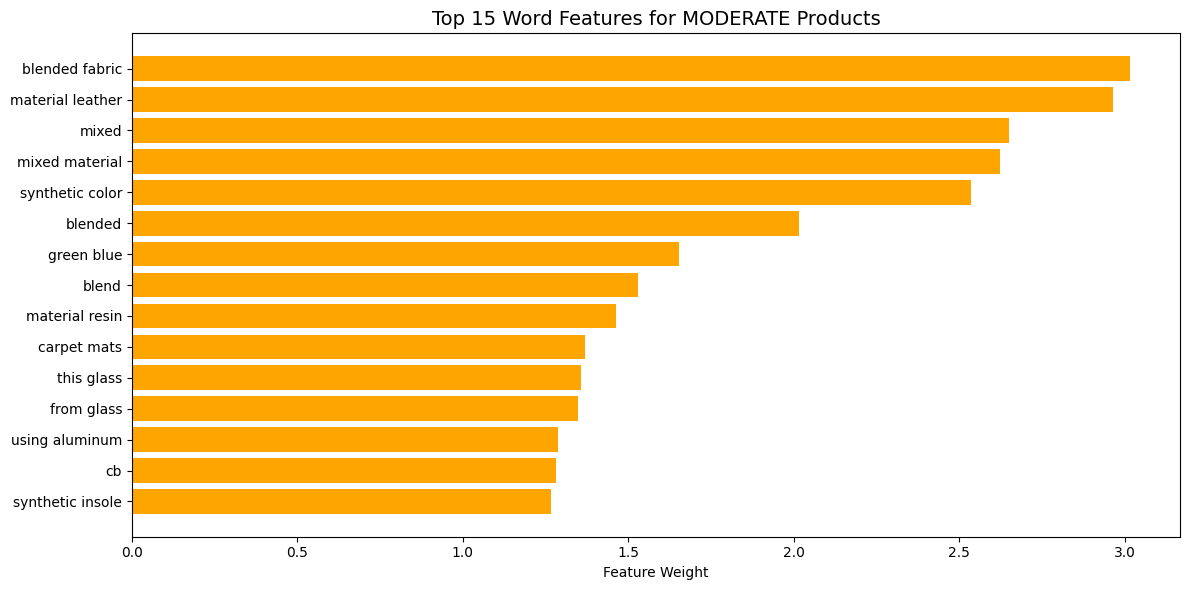

In [ ]:
# ============================
# 📊 Top Important WORD Features (Moderate)
# ============================

vectorizer = best_model.named_steps['features'].transformer_list[0][1]
classifier = best_model.named_steps['clf']

feature_names = vectorizer.get_feature_names_out()
word_coefs = classifier.coef_[1][:len(feature_names)]   # class 1 = Moderate

top_idx = np.argsort(word_coefs)[-15:]

plt.figure(figsize=(12,6))
plt.barh(feature_names[top_idx], word_coefs[top_idx], color="orange")
plt.title("Top 15 Word Features for MODERATE Products", fontsize=14)
plt.xlabel("Feature Weight")
plt.tight_layout()
plt.show()


This block extracts the most impactful **word-level features** for the *moderate* eco-friendliness class based on the model’s learned weights. It displays the top 15 contributing words in a horizontal bar chart to help understand which terms influence moderate classification.


In [ ]:
# ============================
# 7️⃣ Evaluation on TRAINING data
# ============================
y_train_pred = best_model.predict(X_train)

print("\nTraining Accuracy:", accuracy_score(y_train, y_train_pred))
print("\nTraining Classification Report:\n")
print(classification_report(
    y_train, y_train_pred,
    target_names=["Not Eco-Friendly", "Moderate", "Eco-Friendly"]
))



Training Accuracy: 0.9993861802876184

Training Classification Report:

                  precision    recall  f1-score   support

Not Eco-Friendly       1.00      1.00      1.00      6469
        Moderate       1.00      1.00      1.00      5305
    Eco-Friendly       1.00      1.00      1.00     11034

        accuracy                           1.00     22808
       macro avg       1.00      1.00      1.00     22808
    weighted avg       1.00      1.00      1.00     22808



This block evaluates the model’s performance on the **training data**, computing the overall accuracy and displaying a detailed classification report. It helps check how well the model has learned patterns from the training set and whether overfitting might be occurring.


In [ ]:
# ============================
# 7️⃣ Evaluation on TESTING data
# ============================
y_pred = best_model.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(
    y_test, y_pred,
    target_names=["Not Eco-Friendly", "Moderate", "Eco-Friendly"]
))


Accuracy: 0.9838653104173974

Classification Report:

                  precision    recall  f1-score   support

Not Eco-Friendly       0.98      0.98      0.98      1618
        Moderate       0.97      0.99      0.98      1326
    Eco-Friendly       0.99      0.98      0.99      2758

        accuracy                           0.98      5702
       macro avg       0.98      0.98      0.98      5702
    weighted avg       0.98      0.98      0.98      5702



This block evaluates the model’s performance on the **unseen testing data** by calculating accuracy and generating a classification report. It shows how well the model generalizes to new data and provides precision, recall, and F1-score for each class.


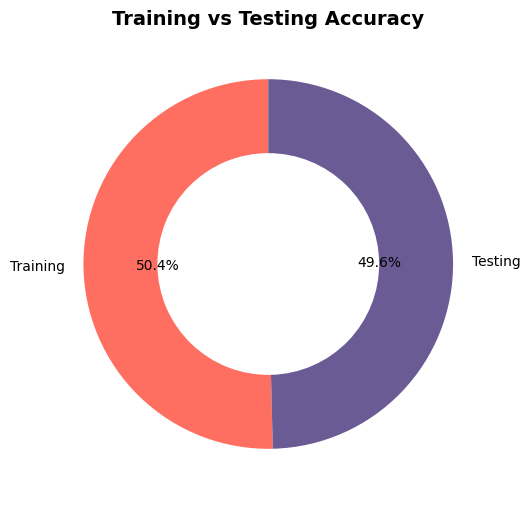

In [ ]:
# ============================
# 📊 Train vs Test Accuracy – Donut Chart
# ============================

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_pred)

sizes = [train_acc, test_acc]
labels = ["Training", "Testing"]
colors = ["#FF6F61", "#6B5B95"]  # coral & purple

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
        startangle=90, wedgeprops={'width':0.4})

plt.title("Training vs Testing Accuracy", fontsize=14, fontweight="bold")
plt.show()


This block compares the model’s **training and testing accuracy** using a donut chart for clear visual contrast. It helps identify if the model is overfitting or generalizing well by visually showing the performance difference between the two sets.


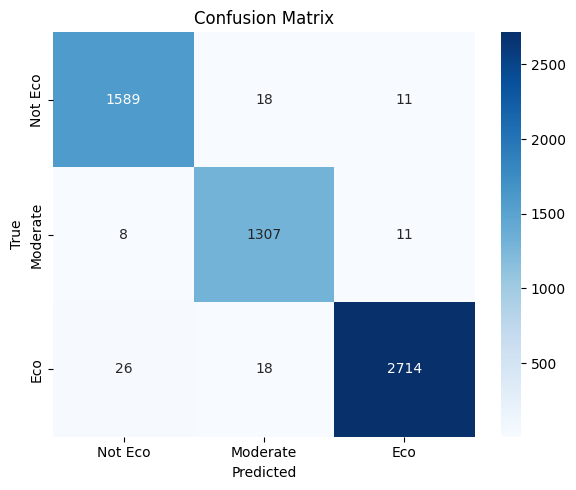

In [ ]:
# ============================
# 8️⃣ Confusion Matrix
# ============================
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Not Eco", "Moderate", "Eco"],
    yticklabels=["Not Eco", "Moderate", "Eco"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


This block visualizes the confusion matrix using a heatmap to show correct and incorrect predictions for each class. It helps analyze which eco-friendliness categories are being confused by the model and where most misclassifications occur.


In [ ]:
# ============================
# 9️⃣ Save Best Model
# ============================
joblib.dump(best_model, "eco_friendly_model_optimized.joblib")
print("\nModel saved as eco_friendly_model_optimized.joblib")


Model saved as eco_friendly_model_optimized.joblib


This block saves the trained and optimized model to a file using Joblib for future use. It allows the model to be easily loaded later for predictions without the need to retrain it.


In [ ]:
# =============================
# 🔟 Prediction Function
# =============================
def predict_product(text):
    cleaned = clean_text(text)
    pred = best_model.predict([cleaned])[0]
    mapping = {0: "Not Eco-Friendly", 1: "Moderate", 2: "Eco-Friendly"}
    return mapping[pred]

# Test
tests = [
    "Bamboo toothbrush biodegradable eco",
    "Plastic bucket heavy duty",
    "Organic cotton bedsheet natural fabric",
    "Disposable plastic plates",
]

print("\nSample Predictions:\n")
for t in tests:
    print(f"{t} → {predict_product(t)}")


Sample Predictions:

Bamboo toothbrush biodegradable eco → Eco-Friendly
Plastic bucket heavy duty → Not Eco-Friendly
Organic cotton bedsheet natural fabric → Eco-Friendly
Disposable plastic plates → Not Eco-Friendly


This block defines a prediction function that cleans new product text, uses the trained model to classify it, and maps the result to a readable eco-friendly label. It then tests the function on sample product descriptions to demonstrate how the model works in real-time.
